# Credit Card fraud detection using Autoencoders

It's Sunday morning, it's quiet and you wake up with a big smile on your face. Today is going to be a great day! Except, your phone rings, rather "internationally". You pick it up slowly and hear something really bizarre - "Bonjour, je suis Michele. Oops, sorry. I am Michele, your personal bank agent.". What could possibly be so urgent for someone from Switzerland to call you at this hour? "Did you authorize a transaction for $3,358.65 for 100 copies of Diablo 3?" Immediately, you start thinking of ways to explain why you did that to your loved one. "No, I didn't !?". Michele's answer is quick and to the point - "Thank you, we're on it". Whew, that was close! But how did Michele knew that this transaction was suspicious? After all, you did order 10 new smartphones from that same bank account, last week - Michele didn't call then.


Annual global fraud losses reached 21.8 billion dollars in 2015, according to Nilson Report.
Probably you feel very lucky if you are a fraud. About every 12 cents per $100 were stolen in the US during the same year. Our friend Michele might have a serious problem to solve here.


Here, we will train an Autoencoder Neural Network (implemented in Keras) in unsupervised (or semi-supervised) fashion for Anomaly Detection in credit card transaction data. The trained model will be evaluated on pre-labeled and anonymized dataset.


### Setup

In [17]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]


### Loading the data


The dataset we're going to use can be downloaded from Kaggle. It contains data about credit card transactions that occurred during a period of two days, with 492 frauds out of 284,807 transactions.

All variables in the dataset are numerical. The data has been transformed using PCA transformation(s) due to privacy reasons. The two features that haven't been changed are Time and Amount. Time contains the seconds elapsed between each transaction and the first transaction in the dataset.


In [18]:
df = pd.read_csv("creditcard.csv")


### Exploration

In [19]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:


In [20]:
df.isnull().values.any()

False

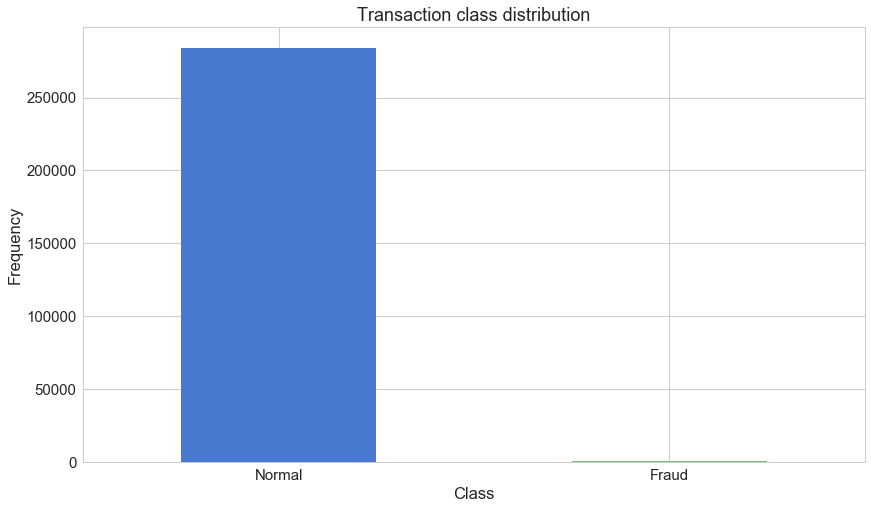

In [21]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");


We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:


In [22]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [23]:
frauds.shape 

(492, 31)

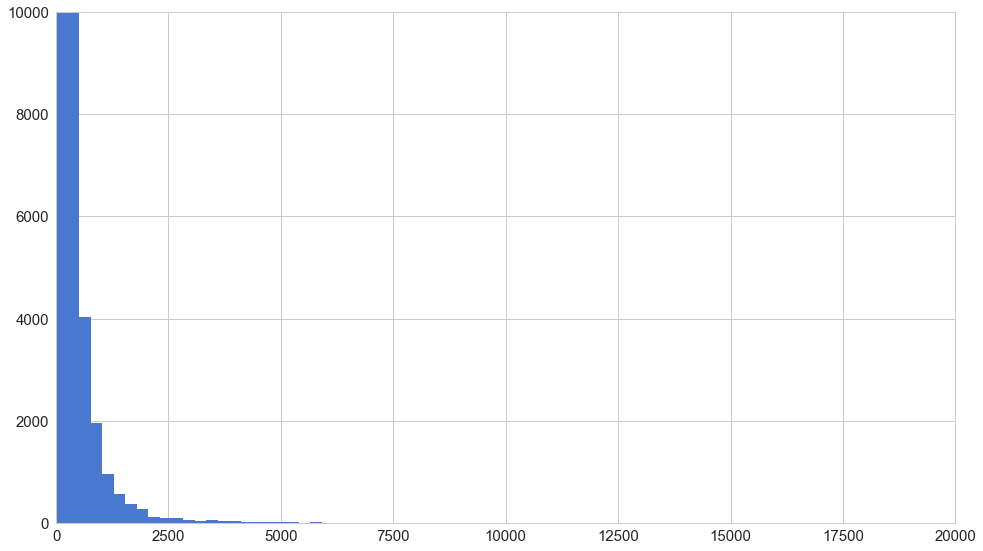

In [24]:
plt.hist(normal.Amount, bins = 100)
plt.xlim([0,20000])
plt.ylim([0,10000])
plt.tight_layout()

### Let's have a more graphical representation:


Text(0.5,1,'Frauds')

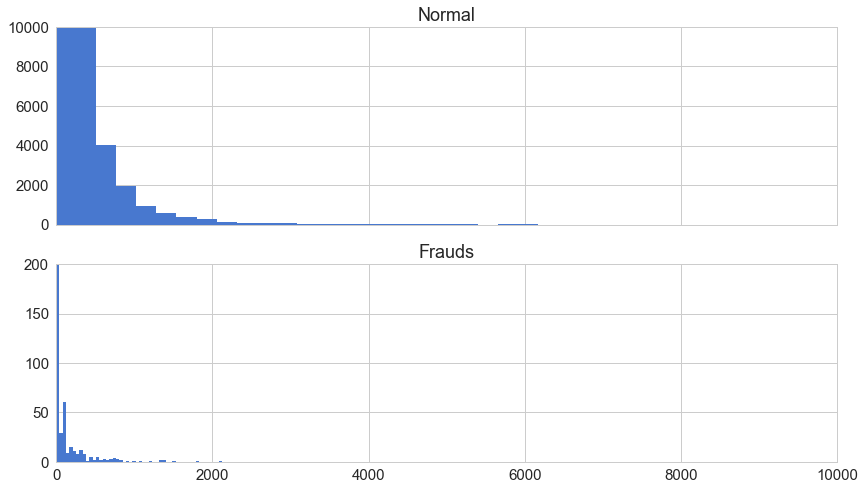

In [25]:
f, axes = plt.subplots(nrows = 2, ncols = 1, sharex = True)

axes[0].hist(normal.Amount, bins = 100)
axes[0].set_xlim([0,20000])
axes[0].set_ylim([0,10000])
axes[0].set_title('Normal')


axes[1].hist(frauds.Amount, bins = 50)
axes[1].set_xlim([0,10000])
axes[1].set_ylim([0,200])
axes[1].set_title('Frauds')


## Autoencoders

Lets get started with autoencoders and we optimize the parameters of our Autoencoder model in such way that a special kind of error -Rreconstruction Error is minimized. In practice, the traditional squared error is often used:
$$\textstyle L(x,x') = ||\, x - x'||^2$$

### Preparing the data

First, let's drop the Time column (not going to use it) and use the scikit's StandardScaler on the Amount. The scaler removes the mean and scales the values to unit variance:


In [26]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))


Training our Autoencoder is gonna be a bit different from what we are used to. Let's say you have a dataset containing a lot of non fraudulent transactions at hand. You want to detect any anomaly on new transactions. We will create this situation by training our model on the normal transactions, only. Reserving the correct class on the test set will give us a way to evaluate the performance of our model. We will reserve 20% of our data for testing:


In [27]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values


In [28]:
X_train.shape

(227451, 29)

### Building the model


Our Autoencoder uses 4 fully connected layers with 14, 7, 7 and 29 neurons respectively. The first two layers are used for our encoder, the last two go for the decoder. Additionally, L1 regularization will be used during training:


In [29]:
input_dim = X_train.shape[1]
encoding_dim = 32


In [30]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="sigmoid")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='sigmoid')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

Let's train our model for 200 epochs with a batch size of 32 samples and save the best performing model to a file. The ModelCheckpoint provided by Keras is really handy for such tasks. Additionally, the training progress will be exported in a format that TensorBoard understands.


In [31]:
import h5py as h5py


In [32]:

nb_epoch = 100
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                              verbose=0,
                             save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                         histogram_freq=0,
                          write_graph=True,
                       write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1, callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/100
227451/227451 [==============================] - 17s 75us/step - loss: 0.9167 - acc: 0.4643 - val_loss: 0.9067 - val_acc: 0.5274
Epoch 2/100
227451/227451 [==============================] - 17s 73us/step - loss: 0.8659 - acc: 0.5431 - val_loss: 0.8769 - val_acc: 0.5646
Epoch 3/100
227451/227451 [==============================] - 17s 73us/step - loss: 0.8390 - acc: 0.5754 - val_loss: 0.8621 - val_acc: 0.5740
Epoch 4/100
227451/227451 [==============================] - 17s 74us/step - loss: 0.8262 - acc: 0.5891 - val_loss: 0.8503 - val_acc: 0.5928
Epoch 5/100
227451/227451 [==============================] - 17s 73us/step - loss: 0.8130 - acc: 0.6100 - val_loss: 0.8346 - val_acc: 0.6231
Epoch 6/100
227451/227451 [==============================] - 16s 72us/step - loss: 0.8007 - acc: 0.6277 - val_loss: 0.8352 - val_acc: 0.6189
Epoch 7/100
227451/227451 [==============================] - 17s 74us/step - loss: 0.7937 - acc: 0.6347

227451/227451 [==============================] - 16s 70us/step - loss: 0.7647 - acc: 0.6712 - val_loss: 0.7976 - val_acc: 0.6633
Epoch 59/100
227451/227451 [==============================] - 16s 68us/step - loss: 0.7643 - acc: 0.6717 - val_loss: 0.7952 - val_acc: 0.6685
Epoch 60/100
227451/227451 [==============================] - 17s 77us/step - loss: 0.7650 - acc: 0.6701 - val_loss: 0.7952 - val_acc: 0.6728
Epoch 61/100
227451/227451 [==============================] - 15s 68us/step - loss: 0.7648 - acc: 0.6704 - val_loss: 0.7982 - val_acc: 0.6553
Epoch 62/100
227451/227451 [==============================] - 16s 71us/step - loss: 0.7645 - acc: 0.6709 - val_loss: 0.8000 - val_acc: 0.6522
Epoch 63/100
227451/227451 [==============================] - 16s 70us/step - loss: 0.7652 - acc: 0.6701 - val_loss: 0.7953 - val_acc: 0.6696
Epoch 64/100
227451/227451 [==============================] - 16s 70us/step - loss: 0.7644 - acc: 0.6718 - val_loss: 0.7969 - val_acc: 0.6663
Epoch 65/100
227451

In [33]:
autoencoder = load_model('model.h5')

### Evaluation

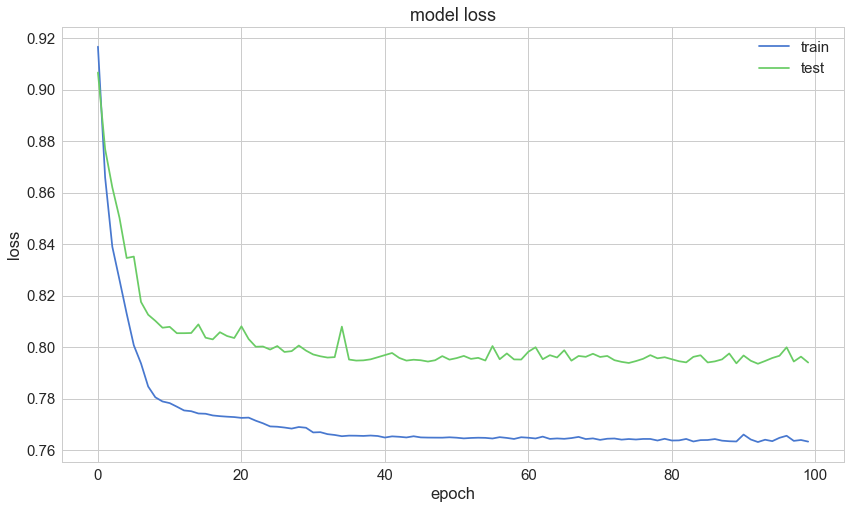

In [34]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:


In [35]:
predictions = autoencoder.predict(X_test)


In [36]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.790553,0.001720
std,3.461215,0.041443
min,0.069604,0.000000
25%,0.258094,0.000000
50%,0.405381,0.000000
75%,0.646277,0.000000
max,259.243414,1.000000


### Reconstruction error without fraud

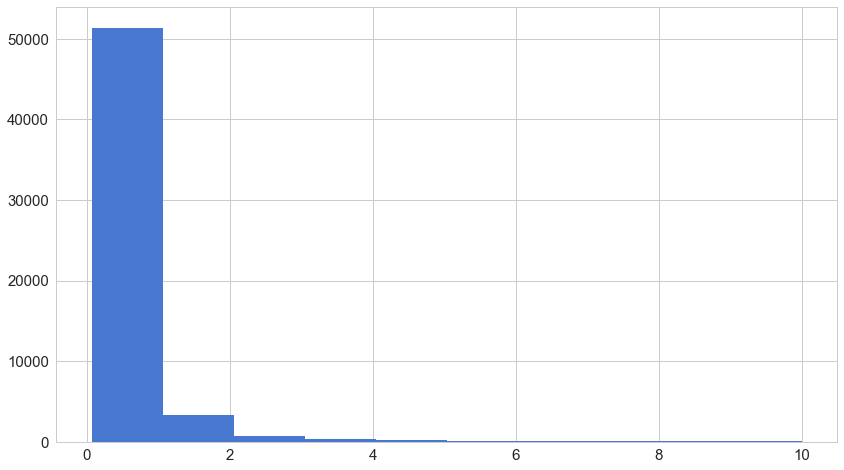

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

### Reconstruction error with fraud


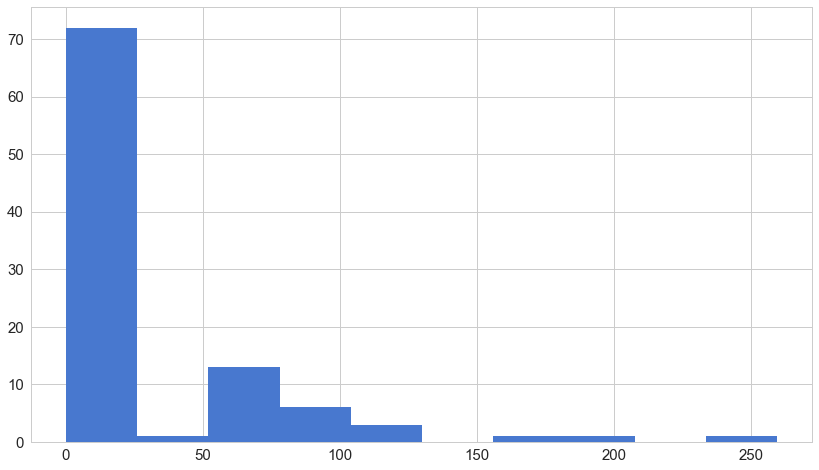

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

### Prediction

Our model is a bit different this time. It doesn't know how to predict new values. But we don't need that. In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:


In [39]:
threshold = 2.9

And see how well we're dividing the two types of transactions:

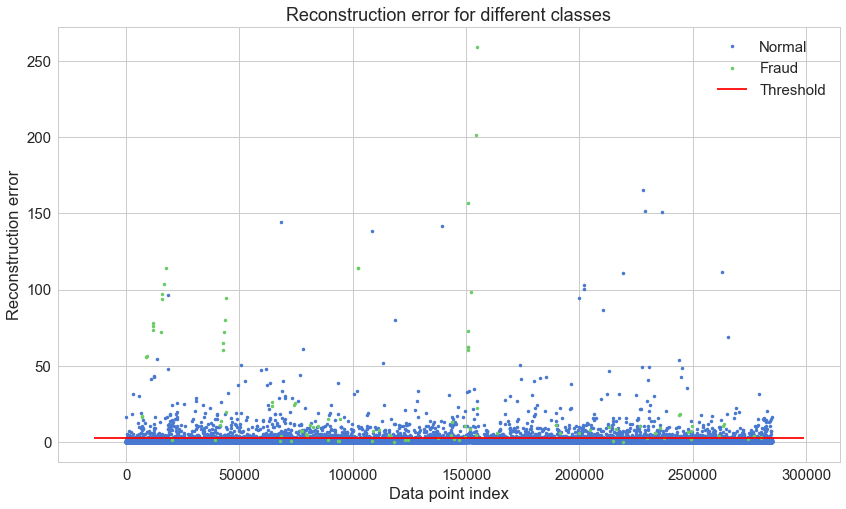

In [40]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

That chart might be a bit deceiving. Let's have a look at the confusion matrix:

In [42]:
from sklearn.metrics import (confusion_matrix)

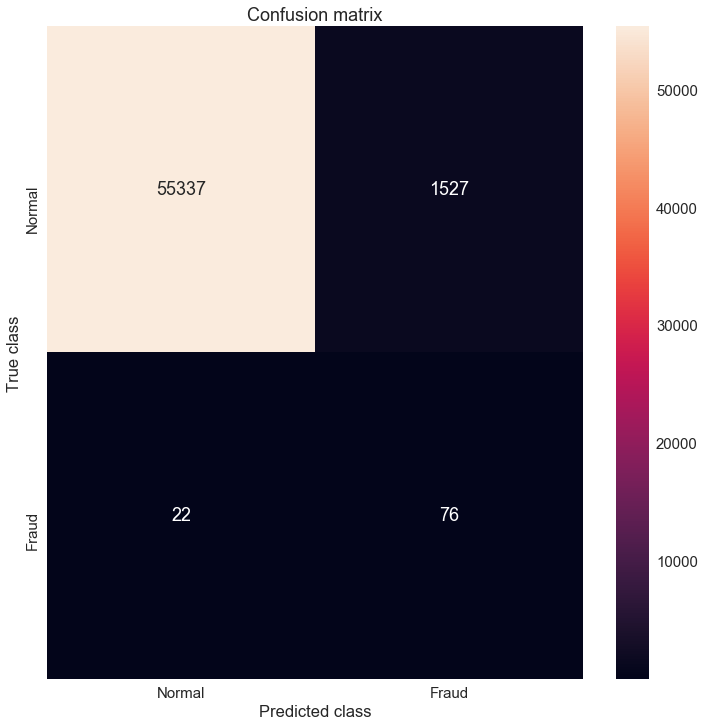

In [47]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

### Conclusion


We've created a very simple Deep Autoencoder in Keras that can reconstruct what non fraudulent transactions looks like. Think about it, we gave a lot of one-class examples (normal transactions) to a model and it learned (somewhat) how to discriminate whether or not new examples belong to that same class. Isn't that cool? Our dataset was kind of magical, though. We really don't know what the original features look like.

Keras gave us very clean and easy to use API to build a non-trivial Deep Autoencoder. 
